# Imports

In [1]:
import pandas as pd, numpy as np, gc, pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [2]:
def reduce_mem_usage(df, verbose=True):
    '''
    takes in a dataframe and optimizes the data types of numeric columns according to the range of values in them
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 # conversion from bytes to Mb
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('collecting garbage gc.collect()')
    gc.collect()
    if verbose:
        print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Read training data

In [3]:
df_train = pd.read_csv('df_train_regress_lag.csv',dtype ={'Customer ID':'object'})

In [4]:
df_train = reduce_mem_usage(df_train)

collecting garbage gc.collect()
Memory usage decreased to 141.84 Mb (68.3% reduction)


In [5]:
# replacing inf values in price with mean as it was causing problem during fitting model
df_train.loc[np.isinf(df_train.price),'price'] = np.mean(df_train[~np.isinf(df_train.price)]['price'])

# creatinng if_ordered column  
this column will provide whether an order was placed in the visit
0 = if no order was placed 
1 = if order was placed

In [6]:
df_train.loc[df_train['Quantity'] < 1,'if_ordered'] = 0

In [7]:
df_train.loc[df_train['Quantity'] >= 1, 'if_ordered'] = 1

In [8]:
df_train.if_ordered.unique()

array([0., 1.])

# order_category

In [9]:
#df_train.loc[df_train['Quantity'] < 1,'order_category'] = 0

In [10]:
#df_train.loc[(df_train['Quantity'] >= 1) & (df_train['Quantity'] <= 10),'order_category'] = 1

In [11]:
#df_train.loc[(df_train['Quantity'] > 10) & (df_train['Quantity'] <= 150),'order_category'] = 2

In [12]:
#df_train.loc[df_train['Quantity'] > 150,'order_category'] = 3

In [13]:
#df_train.order_category.unique()

# separating 0 and 1 if_ordered

In [14]:
df_0 = df_train[df_train['if_ordered'] == 0]

In [15]:
df_1 = df_train[df_train['if_ordered'] == 1]

In [16]:
print(df_train.shape)
print(df_0.shape)
print(df_1.shape)
print(df_0.shape[0]+df_1.shape[0])

(1957002, 31)
(1779072, 31)
(177930, 31)
1957002


In [17]:
print('percentage of 1s in training data')
print((df_1.shape[0]*100)/df_train.shape[0])

percentage of 1s in training data
9.091968224866402


# Classification

## Sampling to create data on which Classifier will be modelled

we are taking all data points where customer ordered for training classifier.  
This will be 40% of total data points used classification.  
The rest 60% will be data points or visits where no order was placed. We will pick the sample using STRATIFIED SAMPLING to select data points from all months for training classifier.

In [62]:
print('%age of data points with order')
perc_1_train = 0.4
print(perc_1_train)


print('total no. of data points to be used to train classifier, which will be all the visits where order was made')
total_1_points = df_1.shape[0]
total_train_data_points = int(total_1_points/perc_1_train)
print(total_train_data_points)

print('no. of data points we require where no order was placed')
total_0_points = total_train_data_points-total_1_points
print(total_0_points)

%age of data points with order
0.4
total no. of data points to be used to train classifier, which will be all the visits where order was made
444825
no. of data points we require where no order was placed
266895


In [63]:
# selecting calcualted no. of 0 order visits for training
# this will be stratified sampling maintaining month and customer cluster proportion
perc_train_from_all0 = total_0_points/df_0.shape[0]
print(perc_train_from_all0)

0.15001922350528815


In [64]:
#X_0 = df_0[[col for col in df_0.columns if col not in ['if_ordered','order_category']]]
X_0 = df_0[[col for col in df_0.columns if col not in ['if_ordered']]]
#Y_0 = df_0[['order_category']]
Y_0 = df_0[['if_ordered']]

In [65]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split( X_0, Y_0, train_size=perc_train_from_all0, 
                                                            random_state=42, stratify=X_0[['month','Customer_Cluster']])

In [66]:
print(X_train_0.shape)
print(y_train_0.shape)

(266895, 30)
(266895, 1)


In [67]:
#X_train_1 = df_1[[col for col in df_1.columns if col not in ['if_ordered','order_category']]]
X_train_1 = df_1[[col for col in df_1.columns if col not in ['if_ordered']]]
#y_train_1 = df_1[['order_category']]
y_train_1 = df_1[['if_ordered']]

In [68]:
X_train_1.shape

(177930, 30)

In [69]:
X = X_train_0.append(X_train_1).reset_index(drop=True)
y = y_train_0.append(y_train_1).reset_index(drop=True)

In [70]:
X.shape

(444825, 30)

In [71]:
y.shape

(444825, 1)

## RandomForestClassifier

## creating train and test

In [72]:
independent_features = [col for col in X.columns if col not in  
                        ['Customer ID','Quantity','Invoice Value','Date','month','year']]

In [73]:
x_train, x_test, y_train, y_test = train_test_split( X[independent_features], y, test_size=0.33, random_state=102, stratify=y) 

### Using GridSearchCV to find best parameters

In [74]:
rfc = RandomForestClassifier(n_jobs=-1,random_state = 101) 

param_grid = { 
    'n_estimators': [100,200, 500],
    'max_depth': [2,5,10, 20, 30, None],
    'max_features':['auto','sqrt']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 3, n_jobs = -1)

In [75]:
#CV_rfc.fit(x_train.values,y_train.values)
#print(CV_rfc.best_params_)

In [76]:
clf=RandomForestClassifier(n_jobs=-1)

In [77]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298032 entries, 264454 to 233339
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   dayofmonth_sin           298032 non-null  float16
 1   dayofmonth_cos           298032 non-null  float16
 2   month_sin                298032 non-null  float16
 3   month_cos                298032 non-null  float16
 4   week_sin                 298032 non-null  float16
 5   week_cos                 298032 non-null  float16
 6   dayofweek_sin            298032 non-null  float16
 7   dayofweek_cos            298032 non-null  float16
 8   quarter_sin              298032 non-null  float16
 9   quarter_cos              298032 non-null  float16
 10  month_start_mid_end_sin  298032 non-null  float16
 11  month_start_mid_end_cos  298032 non-null  float16
 12  price                    298032 non-null  float64
 13  Customer_Cluster         298032 non-null  int8   
 14 

In [78]:
x_train.columns

Index(['dayofmonth_sin', 'dayofmonth_cos', 'month_sin', 'month_cos',
       'week_sin', 'week_cos', 'dayofweek_sin', 'dayofweek_cos', 'quarter_sin',
       'quarter_cos', 'month_start_mid_end_sin', 'month_start_mid_end_cos',
       'price', 'Customer_Cluster', 'quantity_lag_1', 'quantity_lag_2',
       'quantity_lag_3', 'quantity_lag_4', 'quantity_lag_5', 'quantity_lag_6',
       'quantity_ma_3', 'quantity_ma_7', 'quantity_ma_15', 'quantity_ma_30'],
      dtype='object')

In [79]:
clf.fit(x_train,y_train)

<ipython-input-79-23a7f0d6d621>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


RandomForestClassifier(n_jobs=-1)

In [80]:
y_pred=clf.predict(x_test)

In [81]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9978813703650719


In [82]:
confusion_matrix(y_test, y_pred )

array([[87924,   152],
       [  159, 58558]], dtype=int64)

In [83]:
metrics.precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
# precision
# recall
# f1 score

(array([0.99819488, 0.997411  ]),
 array([0.99827422, 0.9972921 ]),
 array([0.99823455, 0.99735155]),
 array([88076, 58717], dtype=int64))

### Classifier Feature Importance

In [56]:
len(features_c)

24

Text(0.5, 0, 'Relative Importance')

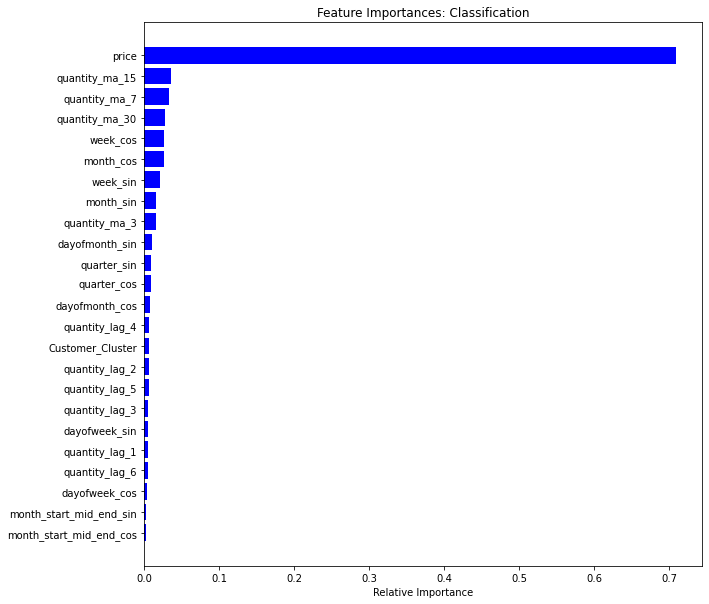

In [58]:
features_c=x_train.columns
importances_c = clf.feature_importances_
indices = np.argsort(importances_c)

plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances: Classification')
plt.barh(range(len(indices)), importances_c[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_c[indices])
plt.xlabel('Relative Importance')

## saving classifer to disk using pickle

In [41]:
# save the model to disk
filename = 'classifier.sav'
pickle.dump(clf, open(filename, 'wb'))

 load the model from disk
clf2 = pickle.load(open(filename, 'rb'))

# Regression  
for regression we are taking all the data points where we have at least one order

## Outliers  
orders with more than 350 can be considered outliers and may be simply removed from training

In [84]:
x_1 = df_1[[col for col in df_1.columns if col != 'Quantity']]
y_1 = df_1[['Quantity']]

## Creating train and test

In [85]:
independent_features = [col for col in x_1.columns if col not in  
                        ['Customer ID','Invoice Value','Date','month','year','if_ordered','order_category']]

In [86]:
x_train, x_test, y_train, y_test = train_test_split( x_1[independent_features], y_1, 
                                                    test_size=0.33, random_state=102, 
                                                    stratify=x_1[['month','Customer_Cluster']]) 

### Using GridSearchCV to find best parameters

In [87]:
rfr = RandomForestRegressor(n_jobs=-1,random_state = 101) 

param_grid = { 
    'n_estimators': [100,200, 500],
    'max_depth': [2,5,10, 20, 30, None],
    'max_features':['auto','sqrt']
}
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv = 3, n_jobs = -1)

In [88]:
#CV_rfr.fit(x_train.values,y_train.values)
#print(CV_rfr.best_params_)

In [89]:
reg_rf = RandomForestRegressor(n_jobs=-1,n_estimators=10, random_state = 102 )

In [90]:
reg_rf.fit(x_train.values,y_train.values)

<ipython-input-90-a23283d3e3e2>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_rf.fit(x_train.values,y_train.values)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=102)

In [91]:
y_pred = reg_rf.predict(x_test)

In [92]:
print('R-squared:', metrics.r2_score(y_test, y_pred) * 100)
print('Mean Absolute percentage Error:', metrics.mean_absolute_error(y_test, y_pred) * 100)  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R-squared: 100.0
Mean Absolute percentage Error: 125.08258962481986
Mean Squared Error: 47.1140387253914
Root Mean Squared Error: 6.863966690288597


C:\Users\avira\.virtualenvs\DecisionPoint_SeriesForecasting-oxTTuEuo\lib\site-packages\sklearn\metrics\_regression.py:600: RuntimeWarning: overflow encountered in square
  denominator = (weight * (y_true - np.average(


**Non Zero Accuracy**

In [117]:
df_nza = pd.DataFrame()
df_nza['y_test_actual'] = y_test.values.flatten()
df_nza['y_test_predicted'] = y_pred

df_nza['y_test_actual'] = df_nza['y_test_actual'].map(int)
df_nza['y_test_predicted'] = df_nza['y_test_predicted'].map(int)

In [121]:
print('Non Zero Accuracy in percentage is')
print(((df_nza.loc[df_nza['y_test_actual'] == df_nza['y_test_predicted']].shape[0]*100))/df_nza.shape[0])

Non Zero Accuracy is
72.32998961118585


# Regression feature importance

Text(0.5, 0, 'Relative Importance')

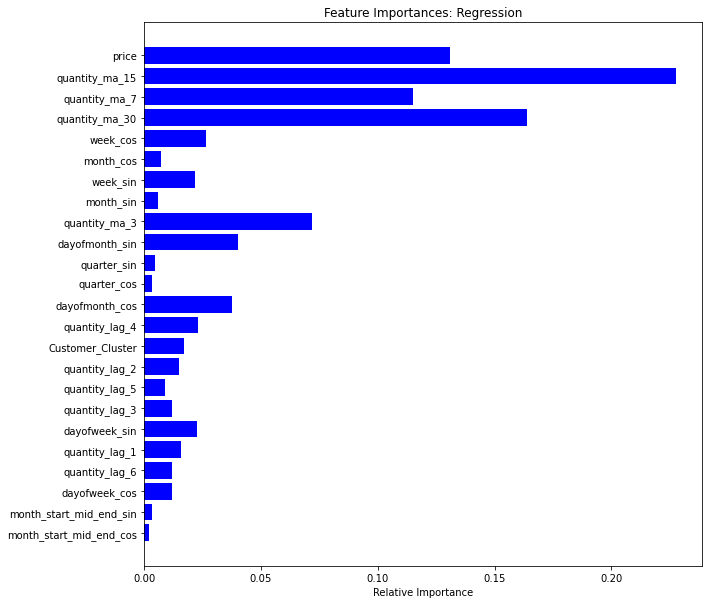

In [59]:
features_r=x_train.columns
importances_r = reg_rf.feature_importances_
indices = np.argsort(importances_c)

plt.figure(figsize=(10,10))
plt.figure(1)
plt.title('Feature Importances: Regression')
plt.barh(range(len(indices)), importances_r[indices], color='b', align='center')
plt.yticks(range(len(indices)), features_r[indices])
plt.xlabel('Relative Importance')

## saving regressor to disk using pickle

In [54]:
filename = 'regressor.sav'
pickle.dump(reg_rf, open(filename, 'wb'))